# PCA - parte 2

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [2]:
# Bibliotecas importantes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# Carregando dados

filename_features = "./input/features.txt"
filename_labels = "./input/activity_labels.txt"

filename_subtrain = "./input/train/subject_train.txt"
filename_xtrain = "./input/train/X_train.txt"
filename_ytrain = "./input/train/y_train.txt"

filename_subtest = "./input/test/subject_test.txt"
ffilename_xtest = "./input/test/X_test.txt"
filename_ytest = "./input/test/y_test.txt"

filename_features = "./input/features.txt"
filename_labels = "./input/activity_labels.txt"

filename_subtrain = "./input/train/subject_train.txt"
filename_xtrain = "./input/train/X_train.txt"
filename_ytrain = "./input/train/y_train.txt"

filename_subtest = "./input/test/subject_test.txt"
ffilename_xtest = "./input/test/X_test.txt"
filename_ytest = "./input/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
labels = pd.read_csv(filename_labels, sep=r'\s+', header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, sep=r'\s+', header=None, names=features.nome_var)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(ffilename_xtest, sep=r'\s+', header=None, names=features.nome_var)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

In [4]:
X_train.shape, y_train.shape, subject_train.shape

((7352, 561), (7352, 1), (7352, 1))

In [5]:
X_test.shape, y_test.shape, subject_test.shape

((2947, 561), (2947, 1), (2947, 1))

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as *variáveis de maior variância tendem a "dominar" a análise*. Nesses casos é comum usar a *padronização das variáveis*.

Faça duas análises de componentes principais para a base do HAR (Human Activity Recognition)- com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

**Função para padronização.**

In [8]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

CPU times: total: 0 ns
Wall time: 0 ns


**Função para o "scree plot"**

Parâmetros da função: 
- Componentes principais: `pcs`
- Número de componentes: `n_comp`
- Variância explicada almejada: `target_explained_vari`
- Critério: `default` = 1 (autovalor padronizado > 1)

In [11]:
# Criando uma função

def screeplot(pcs, n_comp = 0, target_explained_vari=0, criterio=1):
    
    if n_comp > 0:
        ncomp_crit = n_comp
    elif target_explained_vari > 0:
        ncomp_crit = (pcs.explained_variance_ratio_.cumsum() < target_explained_vari).sum() + 1 
        # Critério 1: autovalor padronizado > 1
    elif criterio == 1:
        ncomp_crit = (pcs.explained_variance_ratio_ > 1 / pcs.n_components_).sum()
    else: 
        ncomp_crit = None
    
    fig, ax = plt.subplots(2, 2, sharex=True, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.15, wspace=.15)

    num_componentes = np.arange(pcs.n_components_) + 1
    ax[0,0].plot(num_componentes, pcs.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.65)
    ax[0,0].set_title('Scree Plot - Variância total')
    ax[0,0].set_xlabel('Número de componentes')
    ax[0,0].set_ylabel('Variancia explicada (Autovalores)')
    ax[0,0].grid()

    ax[1,0].plot(num_componentes, pcs.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.65)
    ax[1,0].set_xlabel('Número de componentes')
    ax[1,0].set_ylabel('Variancia explicada (Acumulada)')
    ax[1,0].grid()

    ax[0,1].plot(num_componentes, pcs.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.65)
    ax[0,1].set_title('Scree Plot - Variância percentual')
    ax[0,1].set_xlabel('Número de componentes')
    ax[0,1].set_ylabel('Variancia explicada (percentual)')
    ax[0,1].grid()

    ax[1,1].plot(num_componentes, pcs.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.65)
    ax[1,1].set_xlabel('Número de componentes')
    ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')
    ax[1,1].grid()
    
    if ncomp_crit != None:
        # Linhas verticais de referência
        ax[0,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)

        # linhas horizontais
        variancia               = pcs.explained_variance_[ncomp_crit-1]
        variancia_acumulada     = pcs.explained_variance_.cumsum()[ncomp_crit-1]
        pct_variancia           = pcs.explained_variance_ratio_[ncomp_crit-1]
        pct_variancia_acumulada = pcs.explained_variance_ratio_.cumsum()[ncomp_crit-1]
        
        ax[0,0].axhline(y = variancia              , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,0].axhline(y = variancia_acumulada    , color = 'r', linestyle = '-', linewidth=.5)
        ax[0,1].axhline(y = pct_variancia          , color = 'r', linestyle = '-', linewidth=.5)
        ax[1,1].axhline(y = pct_variancia_acumulada, color = 'r', linestyle = '-', linewidth=.5)


    print(f'Número de componentes:............... {ncomp_crit}')
    print(f'Variância da ultima CP:.............. {variancia:.2f}' )
    print(f'Variância total explicada:........... {variancia_acumulada:.2f}' )
    print(f'Variância percentual da última CP:... {100*pct_variancia:.2f}%' )
    print(f'Variância percentual total explicada: {100*pct_variancia_acumulada:.2f}%' )
    
    # plt.show()
    
    return ncomp_crit

#### Análise com as variáveis não padronizadas¶
Iniciando com a seleção e ordenação das componentes principais

In [13]:
# O número de componentes (colunas) dos dados é 
n_componentes = X_train.shape[1]
n_componentes

561

In [14]:
# Aplicando a Principal component analysis e o fitting

pca = PCA()

# As componentes principais pcs
pcs = pca.fit(X_train)
# Selecionando as componentes principais
pcs_train_components = pcs.transform(X_train)
pcs_test_components = pcs.transform(X_test)

# Criando um dataframe
col_pcs = ['PC'+str(x+1) for x in list(range(n_componentes))]
# Treino e teste
X_train_pcs = pd.DataFrame(pcs_train_components, columns=col_pcs)
X_test_pcs = pd.DataFrame(pcs_test_components, columns=col_pcs) # Esses dados serão utilizada na atividade 2

In [15]:
print(X_train_pcs.shape)
X_train_pcs.head()

(7352, 561)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC552,PC553,PC554,PC555,PC556,PC557,PC558,PC559,PC560,PC561
0,-5.520280,0.290278,1.529929,-1.333242,1.425089,0.194708,0.577454,0.691490,-1.222865,-0.363414,...,3.378634e-09,1.089531e-09,-6.356719e-10,-3.544128e-10,-2.974061e-09,3.145124e-09,-1.557362e-09,-2.130397e-09,-4.361952e-09,2.767221e-09
1,-5.535350,0.082530,1.924804,-0.671273,0.671260,-0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,1.330194e-09,1.788588e-09,4.483718e-09,-1.743250e-09,4.206375e-09,-3.777212e-09,4.088760e-10,-2.335172e-09,2.332010e-10,3.311584e-09
2,-5.474988,-0.287387,2.144642,-0.531806,0.207824,0.037772,0.057628,0.093917,-0.063147,-0.216898,...,-3.552186e-09,-1.072729e-09,-2.686040e-09,1.834708e-09,1.286751e-09,-3.849735e-09,-3.974050e-09,4.308070e-10,3.904869e-10,-4.681536e-11
3,-5.677232,-0.897031,2.018220,-0.157125,0.759085,-1.079547,-0.267805,-0.731391,0.281296,0.466269,...,-5.759364e-09,-2.962761e-09,3.574705e-09,-3.299315e-09,4.232265e-10,2.444560e-09,-1.706000e-09,1.656998e-09,3.217037e-10,6.288701e-09
4,-5.748749,-1.162952,2.139533,-0.207823,0.473090,-0.463035,-0.152227,-0.107509,0.289819,0.539206,...,3.034465e-09,-9.851537e-11,-1.852103e-09,3.508049e-09,2.161852e-09,-5.237441e-09,1.875361e-09,-5.810168e-10,-2.616768e-09,2.562259e-09


In [16]:
# A matrix de autovetores de transformação (redução de dimensionalidade)
print('Dimensão:', pcs.components_.shape)
pcs.components_[:5] # Apresentando as 5 primeiras componentes

Dimensão: (561, 561)


array([[-7.15326815e-05, -2.99847927e-04, -2.31385358e-04, ...,
        -3.60833439e-02,  2.68253762e-02,  2.20742235e-02],
       [-3.25696402e-03,  4.22310864e-04,  8.39509366e-04, ...,
        -3.80396312e-02,  3.83432935e-02,  1.38720372e-02],
       [ 2.45573796e-03,  6.24521615e-04, -3.68280307e-04, ...,
        -2.89236609e-01,  1.24780863e-01,  1.11505431e-01],
       [ 3.26984810e-03,  4.73976881e-04,  5.68385326e-04, ...,
         9.63306700e-03, -3.07883244e-02, -4.77238573e-02],
       [ 4.97786000e-04,  1.62527316e-03,  2.14382545e-03, ...,
        -6.10925430e-02,  1.62030747e-02, -5.94724586e-02]])

In [17]:
# Os autovalores, ou seja, a variância explicada
print('Dimensão dos autovalores: ', pcs.explained_variance_.shape)
pcs.explained_variance_[:5] # Apresentando os 5 primeiros elementos do array

Dimensão dos autovalores:  (561,)


array([34.82363041,  2.73504627,  2.29439284,  1.04377529,  0.943517  ])

Desta forma, podemos dizer que o primeiro autovalor (a componente principal) é capaz de explicar 33.7% da variância dos dados, o segundo 2.6% ...

In [19]:
# Proporção explicada pelas componentes principais

print(pcs.explained_variance_ratio_.shape)
pcs.explained_variance_ratio_[:5] # 5 primeiros elementos do array

# Outra maneira de se obter o mesmo valor
# pcs_train.explained_variance_ / pcs_train.explained_variance_.sum()

(561,)


array([0.6255444 , 0.04913023, 0.04121467, 0.01874956, 0.0169486 ])

Ou seja, a primeira componentes é capaz de explicar ~ 62% da variância dos dados, a segunda ~ 4.8%, ...

In [21]:
# Obtendo a soma comulada das proporções da variância explicada pelas componentes principais
pcs.explained_variance_ratio_.cumsum()[:5] # 5 primeiros elementos

# Interpretação: com uma componente consigo explicar 62.23% dos dados, com as 3 primeiras 71%, ... 
# com todas as componentes 100% dos dados

array([0.6255444 , 0.67467463, 0.7158893 , 0.73463886, 0.75158746])

**Aplicando a função `screeplot` e considerando uma variância explicada de 95%**

Número de componentes:............... 34
Variância da ultima CP:.............. 0.13
Variância total explicada:........... 50.15
Variância percentual da última CP:... 0.24%
Variância percentual total explicada: 90.09%


34

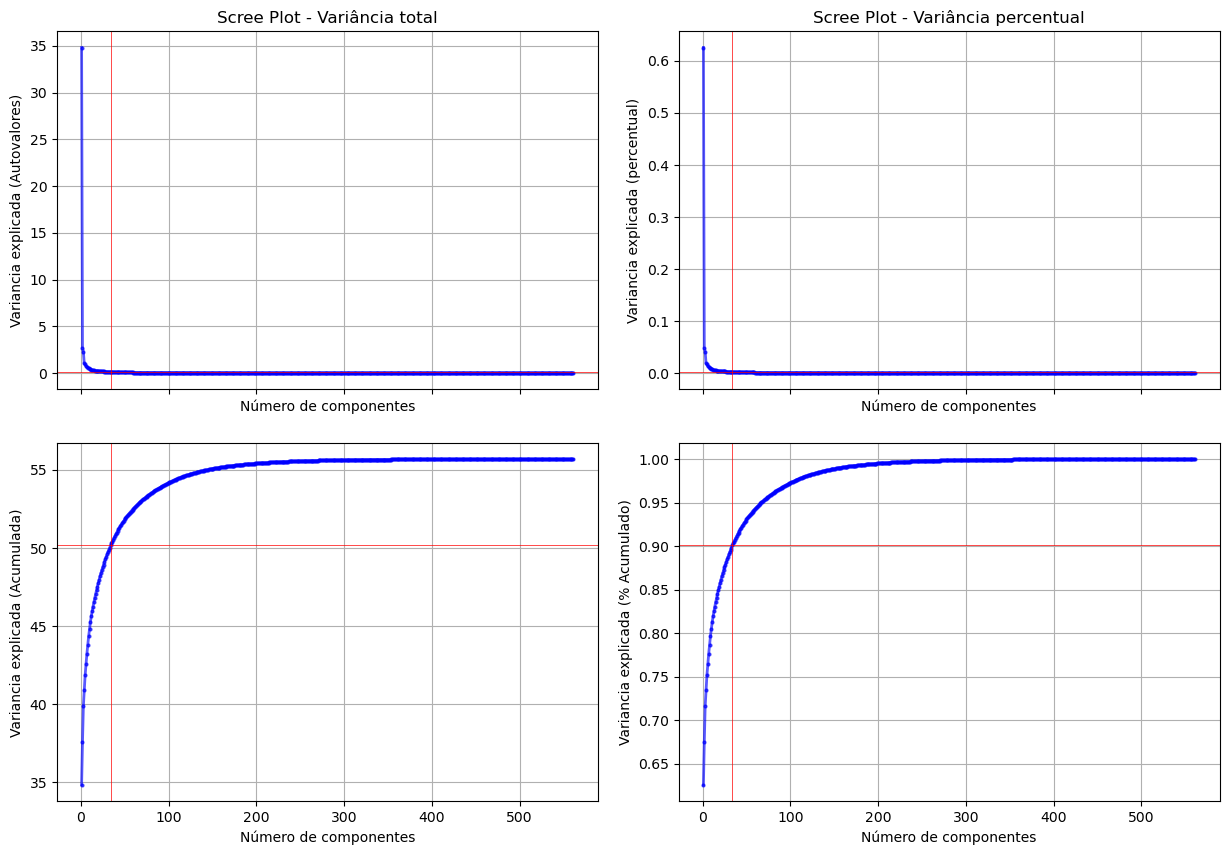

In [23]:
screeplot(pcs=pcs, target_explained_vari=.90)

Com base na análise, para explicar 90% da variância dos dados será necessário considerarmos pelo menos as primeiras 34 componentes principais.

#### Análise com as variáveis **padronizadas**

In [26]:
# Padronizando o dataframe completo

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
print(X_train_pad.shape)
X_train_pad.head()

(7352, 561)


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [27]:
# Para os dados de teste (utilizaremos na atividade 2)
X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)
print(X_test_pad.shape)
X_test_pad.head()

(2947, 561)


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,-0.277661,-0.210595,2.192704,-0.787134,-0.833071,-0.093428,-0.807954,-0.838871,-0.104160,-0.824606,...,-0.253620,-0.166362,-0.344707,0.003565,0.357512,-1.363669,0.575389,-0.404722,0.622618,-0.038342
1,0.198626,0.182560,-0.250221,-0.876836,-0.928903,-0.857905,-0.896993,-0.928791,-0.863122,-0.824606,...,-2.300359,0.490938,0.012254,-0.264048,0.030782,-0.747105,1.870875,-0.361677,0.636623,-0.145684
2,0.024583,-0.318001,-0.228446,-0.921442,-0.933896,-0.906953,-0.916735,-0.933654,-0.912484,-0.910827,...,-0.291514,0.274775,-0.134966,-0.119651,0.445996,0.037913,0.323883,-0.370869,0.632738,-0.126834
3,-0.061047,-0.572940,-0.213673,-0.923681,-0.940657,-0.918926,-0.918996,-0.941439,-0.927619,-0.909586,...,-0.058615,-0.210642,-0.441639,-0.066432,0.338455,0.472614,0.625768,-0.363372,0.645167,-0.117565
4,0.013820,-0.387815,-0.494555,-0.921523,-0.928878,-0.949818,-0.915977,-0.923689,-0.951235,-0.909586,...,-1.090596,-0.810389,-0.796804,-0.022272,-0.098513,1.097162,-0.201965,-0.350197,0.665544,-0.104100


In [28]:
# Avaliando as componentes principais
pca = PCA()
pcs_pad = pca.fit(X_train_pad)
pcs_pad_train_components = pcs_pad.transform(X_train_pad)
pcs_pad_test_components = pcs_pad.transform(X_test_pad)

# Gerando um dataframe
col_names = ['PC'+str(x+1) for x in list(range(X_train_pad.shape[1]))] # Nomes colunas
#treino e teste
df_train_pad = pd.DataFrame(pcs_pad_train_components, columns=col_names)
df_test_pad = pd.DataFrame(pcs_pad_test_components, columns=col_names) # Para atividade 2
df_train_pad.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC552,PC553,PC554,PC555,PC556,PC557,PC558,PC559,PC560,PC561
0,-16.137446,2.151878,-3.144566,0.272446,-6.798476,-4.249105,2.936959,-4.905079,0.775462,3.627490,...,7.597185e-09,-9.857279e-09,-3.228597e-08,1.578300e-08,2.219671e-08,1.501406e-09,-2.604862e-08,1.477181e-08,1.849575e-08,-1.214320e-08
1,-15.295154,1.387049,0.682175,-2.813486,-4.265880,-2.055523,0.011204,-1.845860,-0.492513,0.180162,...,3.286274e-08,-4.415915e-09,-4.250783e-08,3.376641e-09,3.412436e-09,1.863836e-08,-1.283801e-08,-1.257047e-08,-5.060865e-10,-7.558343e-10
2,-15.135989,2.473183,1.756521,-3.717722,-4.181273,-1.357425,0.072942,-1.388094,-0.539717,0.671666,...,-2.531816e-08,-1.190503e-08,2.766122e-08,1.447451e-08,-3.424642e-08,-7.221445e-09,2.621919e-09,-1.786736e-08,5.356877e-10,2.116447e-08
3,-15.349840,3.915414,1.790201,-2.567347,-3.205621,-0.942880,0.530700,-1.832060,-1.071444,1.496887,...,-1.234553e-08,-3.190407e-09,1.880769e-08,-2.319823e-09,-2.197847e-08,1.910968e-08,6.161549e-09,-1.712316e-08,9.800260e-09,-1.044834e-08
4,-15.543756,4.598424,2.188433,-2.897381,-3.079941,-1.061386,-1.048520,-0.816877,-0.600022,-1.118799,...,-9.683321e-09,1.162376e-08,1.680130e-09,-2.512294e-09,-8.386581e-09,-1.676246e-09,1.870418e-08,-3.925941e-08,-2.367594e-08,2.302430e-10


In [29]:
pcs_pad.explained_variance_ratio_.cumsum()[:5]

array([0.50781172, 0.57361853, 0.60168289, 0.62672242, 0.64560527])

Já é possível notar que as componentes principais já não possuem uma variância explicada tão grande quanto antes da padronização.

**Aplicando a função `screeplot` e gerando a análise das variâncias**

Considerando uma variância explicada de 95%.

Número de componentes:............... 63
Variância da ultima CP:.............. 0.99
Variância total explicada:........... 505.20
Variância percentual da última CP:... 0.18%
Variância percentual total explicada: 90.05%


63

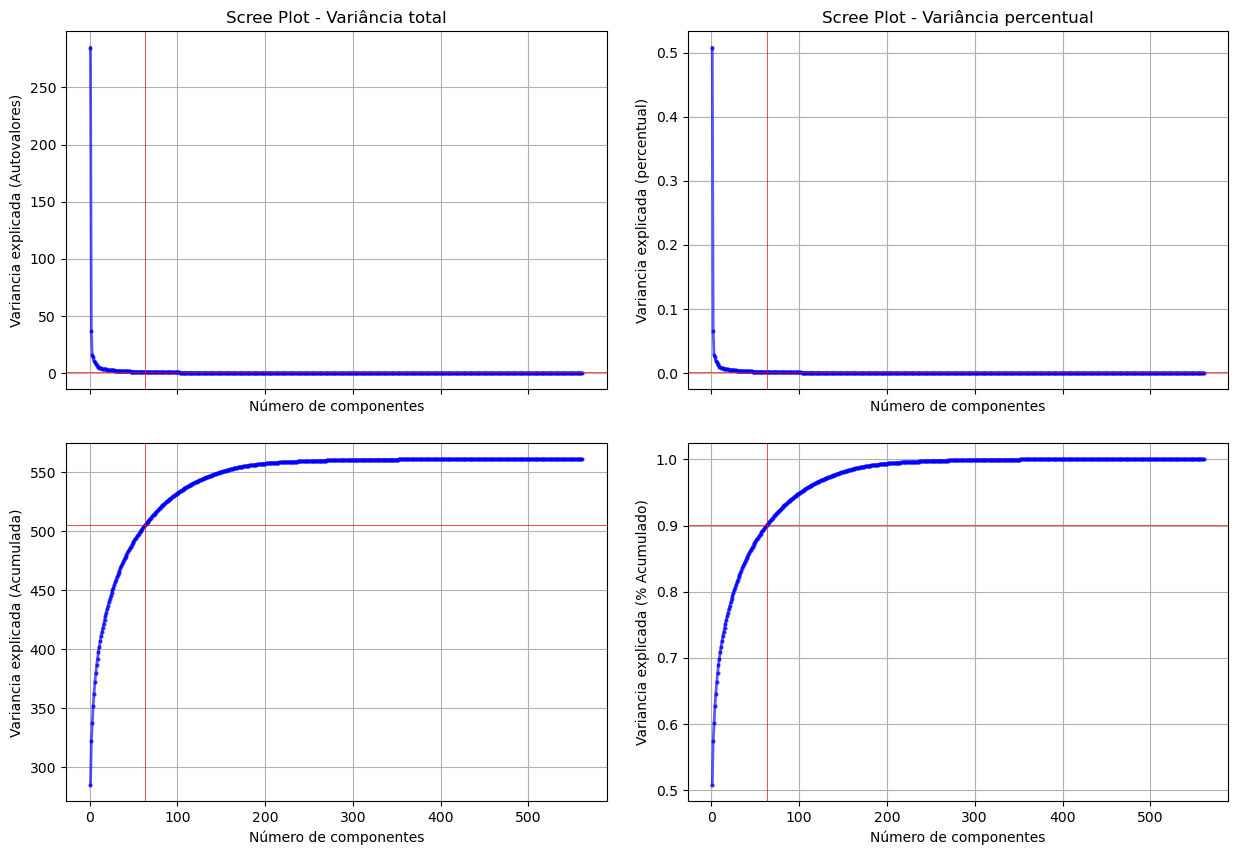

In [32]:
screeplot(pcs = pcs_pad, target_explained_vari=.90)

Com as variáveis padronizadas, para obtermos uma variância explicada de 90% será necessário ao menos as primeiras 65 componentes principais.

## Árvore com PCA

Faça uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

##### Dados não padronizados

In [36]:
# Obtendo as 10 primeiras componentes principais

x_train_pcs = X_train_pcs[list(X_train_pcs.columns[:10])].copy()
x_test_pcs = X_test_pcs[list(X_test_pcs.columns[:10])].copy()
x_train_pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-5.520280,0.290278,1.529929,-1.333242,1.425089,0.194708,0.577454,0.691490,-1.222865,-0.363414
1,-5.535350,0.082530,1.924804,-0.671273,0.671260,-0.735144,-0.616908,-0.771714,-0.615496,-0.895525
2,-5.474988,-0.287387,2.144642,-0.531806,0.207824,0.037772,0.057628,0.093917,-0.063147,-0.216898
3,-5.677232,-0.897031,2.018220,-0.157125,0.759085,-1.079547,-0.267805,-0.731391,0.281296,0.466269
4,-5.748749,-1.162952,2.139533,-0.207823,0.473090,-0.463035,-0.152227,-0.107509,0.289819,0.539206
...,...,...,...,...,...,...,...,...,...,...
7347,6.253517,2.636767,-0.448229,-1.476516,-0.767298,0.268023,-1.348600,-0.463529,1.463389,0.210285
7348,5.782321,2.437814,-0.462731,-1.711345,-0.825446,0.403852,-1.257430,-0.319120,0.424317,-0.814650
7349,5.857505,3.081843,-0.671207,-2.253646,-0.494577,-0.391518,-1.000016,-0.162912,0.291533,1.248849
7350,5.421095,3.426430,-0.671243,-2.013981,-0.612601,-0.443119,-1.445597,-0.112817,0.813037,1.681171


In [37]:
%%time

# Definindo e treinando árvore
clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
clf.fit(x_train_pcs, y_train)

CPU times: total: 93.8 ms
Wall time: 99.9 ms


DecisionTreeClassifier(ccp_alpha=0.001, random_state=1234)

                                  ###### Base de treino ###### 

--> A acurácia na base de treino é de: 89.27%
- Matriz de confusão:


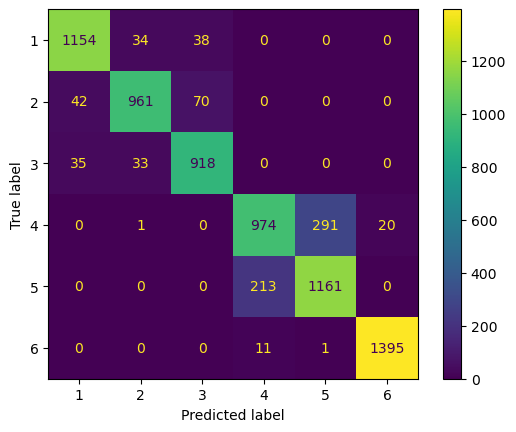


                                ###### Base de teste ###### 

--> A acurácia na base de testes é de: 82.39%
- Matriz de confusão:


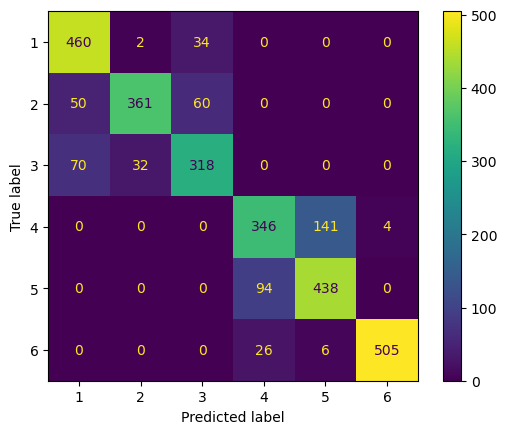

In [38]:
# Analisando a acurácia e a matriz de confusão

print('                                  ###### Base de treino ###### \n')
y_pred_train = clf.predict(x_train_pcs)
print('--> A acurácia na base de treino é de: {:.2f}%'.format(clf.score(x_train_pcs, y_train)*100))
# Matriz de confusão
print('- Matriz de confusão:')
cm = confusion_matrix(y_train, y_pred_train, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()
plt.show()

print('\n                                ###### Base de teste ###### \n')
y_pred = clf.predict(x_test_pcs)
print('--> A acurácia na base de testes é de: {:.2f}%'.format(clf.score(x_test_pcs, y_test)*100))
# Matriz de confusão
print('- Matriz de confusão:')
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()
plt.show()

##### Dados padronizados

In [40]:
# Selecionando as 10 componentes principais
#treino
X_train_pad = df_train_pad[list(df_train_pad.columns[:10])].copy()
X_train_pad.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-16.137446,2.151878,-3.144566,0.272446,-6.798476,-4.249105,2.936959,-4.905079,0.775462,3.627490
1,-15.295154,1.387049,0.682175,-2.813486,-4.265880,-2.055523,0.011204,-1.845860,-0.492513,0.180162
2,-15.135989,2.473183,1.756521,-3.717722,-4.181273,-1.357425,0.072942,-1.388094,-0.539717,0.671666
3,-15.349840,3.915414,1.790201,-2.567347,-3.205621,-0.942880,0.530700,-1.832060,-1.071444,1.496887
4,-15.543756,4.598424,2.188433,-2.897381,-3.079941,-1.061386,-1.048520,-0.816877,-0.600022,-1.118799


In [41]:
# Teste
X_test_pad = df_test_pad[list(df_test_pad.columns[:10])].copy()
X_test_pad.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-10.943262,-1.860853,-2.227732,-1.065895,-3.609319,-1.066383,3.845616,-2.416068,-3.141914,-1.219280
1,-14.111493,-1.077710,0.396637,-2.594611,-3.288198,1.030781,-0.591518,0.072859,0.544571,-1.924795
2,-15.321644,2.364815,2.252915,-2.112780,-2.126119,-1.015552,1.215975,-1.811183,-2.628442,1.938816
3,-15.574716,1.862374,1.677695,-2.195499,-2.823678,-2.039440,-0.133934,-1.279048,-1.453475,1.854017
4,-14.861252,-1.720390,1.458025,-2.071394,-3.907062,-0.138823,-1.254691,1.304317,-0.207996,-1.022927


In [42]:
%%time

#Definindo e treinando a árvore
clf_pad = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
clf_pad.fit(X_train_pad, y_train)

CPU times: total: 109 ms
Wall time: 91.6 ms


DecisionTreeClassifier(ccp_alpha=0.001, random_state=1234)

                                ###### Base de treino ###### 

--> A acurácia na base de treino é de: 85.87%
- Matriz de confusão:


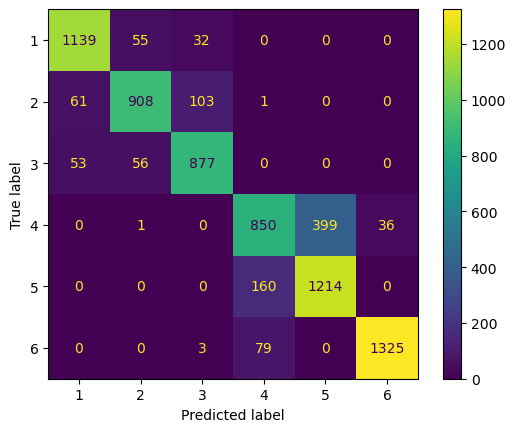


                                ###### Base de teste ###### 

--> A acurácia na base de testes é de: 77.37%
- Matriz de confusão:


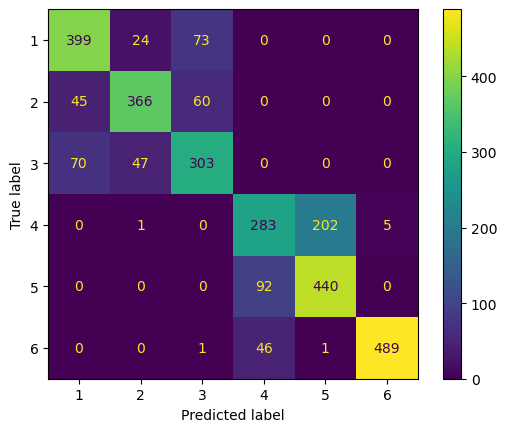

In [43]:
# Analisando a acurácia e a matriz de confusão para os dados padronizados

print('                                ###### Base de treino ###### \n')
y_pred_train = clf_pad.predict(X_train_pad)
print('--> A acurácia na base de treino é de: {:.2f}%'.format(clf_pad.score(X_train_pad, y_train)*100))
# Matriz de confusão
print('- Matriz de confusão:')
cm = confusion_matrix(y_train, y_pred_train, labels=clf_pad.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf_pad.classes_)
disp.plot()
plt.show()


print('\n                                ###### Base de teste ###### \n')
y_pred = clf_pad.predict(X_test_pad)
print('--> A acurácia na base de testes é de: {:.2f}%'.format(clf_pad.score(X_test_pad, y_test)*100))
# Matriz de confusão
print('- Matriz de confusão:')
cm = confusion_matrix(y_test, y_pred, labels=clf_pad.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf_pad.classes_)
disp.plot();